In [1]:
!nvidia-smi

Sat Oct 14 15:28:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as FT
import torchvision.models as models
from torchvision import transforms
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!cp -r '/content/gdrive/My Drive/ERA1/s20_stable_diffusion' '.'

In [5]:
# Define a function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image).unsqueeze(0)
    return image

# Load a reference image and a generated image
reference_image = load_image("/content/s20_stable_diffusion/Val_Data/Winged Drones/wd7.jpg").to('cuda')

In [6]:
# Load a pre-trained VGG model (you can use other models as well)
vgg_model = models.vgg16(pretrained=True).features
vgg_model = vgg_model.to('cuda')
vgg_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 238MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
# Define the layers from which to extract features
feature_layers = ["0", "5", "10", "19", "28", "30"]  # These layers capture high-level features

# Create a new model that extracts features from the chosen layers
feature_extractor = nn.Sequential()
for name, layer in vgg_model._modules.items():
    if name == '0':  # Stop at the 28th layer
        break
    feature_extractor.add_module(name, layer)
feature_extractor

Sequential()

In [ ]:
# feature_extractor.add_module("final", nn.Conv2d(512, 3, 1, 1, 0))
# feature_extractor.add_module("final_0", nn.ReLU())
# feature_extractor

In [ ]:
reference_image

In [9]:
r_img_extr = feature_extractor(reference_image)
r_img_extr.shape

torch.Size([1, 3, 512, 512])

# Huggingface

In [10]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.6 MB/s eta 0:00:00


In [11]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FT
import random
from tqdm import tqdm
import os
import subprocess

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [12]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

(…)fusion-v1-4/resolve/main/vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

(…)it-large-patch14/resolve/main/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

(…)it-large-patch14/resolve/main/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)h14/resolve/main/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

(…)tch14/resolve/main/tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

(…)t-large-patch14/resolve/main/config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

(…)usion-v1-4/resolve/main/unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [13]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()  # [1, 4, 64, 64]

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [14]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

In [15]:
def pattern_loss(images, pattern):
    """
    This function calculates the pattern loss between the output image and the desired pattern.

    Parameters:
    images (torch.Tensor): The output image generated by the Huggingface model.
    pattern (torch.Tensor): The desired pattern that the output image should follow. This is extracted from a pre-trained model in above steps.

    Returns:
    torch.Tensor: The pattern loss between the output image and the desired pattern.
    """
    # Calculate the absolute difference between the model predicetd image and the pattern extracted from pre-trained model(above step).
    diff = torch.abs(images - pattern)
    # Sum the difference over all channels and pixels.
    loss = torch.sum(diff)
    return loss

In [16]:
def perceptual_loss(images, pattern):
    """
    This function calculates the perceptual loss between the output image and the target image.

    Parameters:
    """
    criterion = nn.MSELoss()
    mse_loss = criterion(images, pattern)
    return mse_loss

In [17]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding   # This is CLIPtext we took earlier
pos_emb_layer   = text_encoder.text_model.embeddings.position_embedding

In [18]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [19]:
def get_modified_output_embeddings_wo_style(prompt):
    # Tokenize
    print(f'Prompt input : {prompt}')
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)
    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)
    # Get position embeddings
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    #  Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings
    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)
    return modified_output_embeddings, text_input

In [20]:
def get_modified_output_embeddings(prompt, concept_embed, concept_key, repl_token_num):
    # Tokenize
    print(f'Prompt input : {prompt} --- concept : {concept_key}')
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = text_input.input_ids.to(torch_device)
    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)
    # Get position embeddings
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    # The new embedding - our special birb word or other styles
    replacement_token_embedding = concept_embed[concept_key].to(torch_device)
    # Insert this into the token embeddings wherever our token number (eg: car, puppy etc.) to be replaced is present
    token_embeddings[0, torch.where(input_ids[0]==repl_token_num)] = replacement_token_embedding.to(torch_device)
    #  Combine with pos embs
    input_embeddings = token_embeddings + position_embeddings
    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)
    return modified_output_embeddings, text_input

In [21]:
#Generating image with the modified embeddings with pattern loss guidance and saving the images to steps/{concept} folder
def generate_with_embs_pattern_loss(text_embeddings, text_input, concept_seed, concept):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 200          # Number of denoising steps
    guidance_scale = 8                  # Scale for classifier-free guidance
    generator = torch.manual_seed(concept_seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    pattern_loss_scale = 20
    blue_loss_scale = 200

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),
                           generator=generator,)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG (Classifier Free Guidance)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #### ADDITIONAL GUIDANCE ###
        if i%2 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            latents_x0 = latents - sigma * noise_pred
            # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)
            # Calculate loss
            # loss = blue_loss(denoised_images) * blue_loss_scale
            denoised_images_extr = feature_extractor(denoised_images)
            reference_img_extr = feature_extractor(reference_image)
            # loss = pattern_loss(denoised_images, pattern) * pattern_loss_scale
            # loss = pattern_loss(denoised_images_extr, reference_img_extr) * pattern_loss_scale
            loss = perceptual_loss(denoised_images_extr, reference_img_extr) * pattern_loss_scale
            # Occasionally print it out
            if i%30==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2

        # Now step with scheduler. compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

        if (i%49 == 0) or (i == (num_inference_steps-1)):

            # To PIL Images
            im_t0 = latents_to_pil(latents_x0)[0]
            im_next = latents_to_pil(latents)[0]

            # Combine the two images and save for later viewing
            im = Image.new('RGB', (1024, 512))
            im.paste(im_next, (0, 0))
            im.paste(im_t0, (512, 0))
            im.save(f'steps/{concept}/{i:04}.jpeg')

        if i%449 == 0:
            im_l = Image.new('RGB', (512, 512))
            im_last = latents_to_pil(latents)[0]
            im_l.paste(im_last, (0, 0))
            im_l.save(f'steps/{concept}/{i:04}_Final.jpeg')

    return latents_to_pil(latents)[0]

In [22]:
#Generating an image with the modified embeddings without any loss guidance and saving the images to images_no_loss folder
def generate_with_embs(text_embeddings, concept, concept_seed):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 200            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(concept_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        if i % 50 == 0:
           print(f'i : {i}')

    im_next = latents_to_pil(latents)[0]

    # Save image for later viewing
    im = Image.new('RGB', (512, 512))
    im.paste(im_next, (0, 0))
    im.save(f'/content/steps/images_no_loss/{i:04}_{concept}.jpeg')

    return latents_to_pil(latents)[0]

In [23]:
!rm -rf '/content/steps'

In [24]:
directories = ['anime_bg_v2', 'birb', 'depthmap', 'gta5_artwork', 'midjourney', 'depthmap2']

# Remove the style folders to save the diffuser output images, if they already exists
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    cmd = f"rm -rf {dir_path}"
    output = subprocess.check_output(cmd, shell=True)

# Remove the style folders to save the diffuser output images, if they already exists
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    # construct the shell command to remove the directory
    if os.path.isdir(dir_path):
        os.rmdir(dir_path)
        print(f' Removed - {dir_path}')
    else:
        print(f' Doesnt exist - {dir_path}')

if os.path.exists('/content/steps'):
    print(f'/content/steps exists')
else:
    os.mkdir('/content/steps')
    print(f'Created /content/steps')
    os.mkdir('/content/steps/images_no_loss')
    print(f'Created /content/steps/images_no_loss')

# Create the style folders to save the diffuser output images
for concept in directories:
    dir_path = f'/content/steps/{concept}'
    # construct the shell command to remove the directory
    if os.path.exists(dir_path):
        print(f' Already exists - {dir_path}')
    else:
        os.mkdir(dir_path)
        print(f' Created - {dir_path}')

 Doesnt exist - /content/steps/anime_bg_v2
 Doesnt exist - /content/steps/birb
 Doesnt exist - /content/steps/depthmap
 Doesnt exist - /content/steps/gta5_artwork
 Doesnt exist - /content/steps/midjourney
 Doesnt exist - /content/steps/depthmap2
Created /content/steps
Created /content/steps/images_no_loss
 Created - /content/steps/anime_bg_v2
 Created - /content/steps/birb
 Created - /content/steps/depthmap
 Created - /content/steps/gta5_artwork
 Created - /content/steps/midjourney
 Created - /content/steps/depthmap2


In [25]:
concept_dict={'anime_bg_v2':('/content/s20_stable_diffusion/anime_background_style_v2_embeds.bin',31),
              'birb':('/content/s20_stable_diffusion/birb_embed.bin',32),
              'depthmap':('/content/s20_stable_diffusion/depthmap_embeds.bin',33),
              'gta5_artwork':('/content/s20_stable_diffusion/gta5_artwork_embeds.bin',34),
              'midjourney':('/content/s20_stable_diffusion/midjourney_embeds.bin',35),
              'depthmap2':('/content/s20_stable_diffusion/depthmap_2_embeds.bin', 36)}
              # 'no-style':('/content'),
              # 'no-style2':('/content')}

In [26]:
replacement_word = 'tiger'
repl_token_num = tokenizer(replacement_word)['input_ids'][1]
print(f'tokenizer(prompt): {tokenizer(replacement_word)} repl_token_num : {repl_token_num}')
print('token_emb_layer([token_id]) shape:', token_emb_layer(torch.tensor([repl_token_num], device=torch_device)).shape)

tokenizer(prompt): {'input_ids': [49406, 6531, 49407], 'attention_mask': [1, 1, 1]} repl_token_num : 6531
token_emb_layer([token_id]) shape: torch.Size([1, 768])


- Reference Image

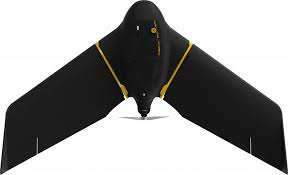

In [27]:
Image.open('/content/s20_stable_diffusion/Val_Data/Winged Drones/wd7.jpg')

In [ ]:
# Generating images without any loss guidance. num_inference_steps = 200.

prompt = 'A boy running in the style of a tiger'

for concept, value in concept_dict.items():
    concept_embed_loc, concept_seed = value
    print(f'concept_embed_loc : {concept_embed_loc} , concept_seed : {concept_seed} ')
    concept_embed = torch.load(concept_embed_loc)
    concept_key = list(concept_embed.keys())[0]
    concept_output_embeddings, text_input = get_modified_output_embeddings(prompt, concept_embed, concept_key, repl_token_num)
    generated_img = generate_with_embs(concept_output_embeddings, concept, concept_seed)

concept_embed_loc : /content/s20_stable_diffusion/anime_background_style_v2_embeds.bin , concept_seed : 31 
Prompt input : A boy running in the style of a tiger --- concept : <anime-background-style-v2>


<ipython-input-30-d88d05ea5662>:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/s20_stable_diffusion/birb_embed.bin , concept_seed : 32 
Prompt input : A boy running in the style of a tiger --- concept : <birb-style>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/s20_stable_diffusion/depthmap_embeds.bin , concept_seed : 33 
Prompt input : A boy running in the style of a tiger --- concept : <depthmap>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/s20_stable_diffusion/gta5_artwork_embeds.bin , concept_seed : 34 
Prompt input : A boy running in the style of a tiger --- concept : <gta5-artwork>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/s20_stable_diffusion/midjourney_embeds.bin , concept_seed : 35 
Prompt input : A boy running in the style of a tiger --- concept : <midjourney-style>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150
concept_embed_loc : /content/s20_stable_diffusion/depthmap_2_embeds.bin , concept_seed : 36 
Prompt input : A boy running in the style of a tiger --- concept : <depthmap>


0it [00:00, ?it/s]

i : 0
i : 50
i : 100
i : 150


In [28]:
# Generating images with pattern loss with style. num_inference_steps = 200
prompt = 'A boy running in the style of a tiger'

for concept, value in concept_dict.items():
    concept_embed_loc, concept_seed = value
    print(f'concept_embed_loc : {concept_embed_loc} concept_seed : {concept_seed} ')
    concept_embed = torch.load(concept_embed_loc)
    concept_key = list(concept_embed.keys())[0]
    concept_output_embeddings, text_input = get_modified_output_embeddings(prompt, concept_embed, concept_key, repl_token_num)
    generated_img = generate_with_embs_pattern_loss(concept_output_embeddings, text_input, concept_seed, concept)

concept_embed_loc : /content/s20_stable_diffusion/anime_background_style_v2_embeds.bin concept_seed : 31 
Prompt input : A boy running in the style of a tiger --- concept : <anime-background-style-v2>


<ipython-input-21-73f80e986ab8>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 4.884084224700928
30 loss: 3.432246208190918
60 loss: 2.926527976989746
90 loss: 2.9104576110839844
120 loss: 2.8168458938598633
150 loss: 2.7642953395843506
180 loss: 2.7678966522216797
concept_embed_loc : /content/s20_stable_diffusion/birb_embed.bin concept_seed : 32 
Prompt input : A boy running in the style of a tiger --- concept : <birb-style>


0it [00:00, ?it/s]

0 loss: 5.908618927001953
30 loss: 3.425839424133301
60 loss: 3.323871612548828
90 loss: 2.6022791862487793
120 loss: 2.6092491149902344
150 loss: 2.68328857421875
180 loss: 2.653128147125244
concept_embed_loc : /content/s20_stable_diffusion/depthmap_embeds.bin concept_seed : 33 
Prompt input : A boy running in the style of a tiger --- concept : <depthmap>


0it [00:00, ?it/s]

0 loss: 7.014788627624512
30 loss: 4.61647367477417
60 loss: 3.869785785675049
90 loss: 3.6425423622131348
120 loss: 3.64864444732666
150 loss: 3.637509822845459
180 loss: 3.6245803833007812
concept_embed_loc : /content/s20_stable_diffusion/gta5_artwork_embeds.bin concept_seed : 34 
Prompt input : A boy running in the style of a tiger --- concept : <gta5-artwork>


0it [00:00, ?it/s]

0 loss: 4.814571380615234
30 loss: 3.489008903503418
60 loss: 2.555074453353882
90 loss: 2.399404525756836
120 loss: 2.4699947834014893
150 loss: 2.4043891429901123
180 loss: 2.398953437805176
concept_embed_loc : /content/s20_stable_diffusion/midjourney_embeds.bin concept_seed : 35 
Prompt input : A boy running in the style of a tiger --- concept : <midjourney-style>


0it [00:00, ?it/s]

0 loss: 7.109827995300293
30 loss: 3.051764488220215
60 loss: 2.0228946208953857
90 loss: 1.7418408393859863
120 loss: 1.6243647336959839
150 loss: 1.6085511445999146
180 loss: 1.6186290979385376
concept_embed_loc : /content/s20_stable_diffusion/depthmap_2_embeds.bin concept_seed : 36 
Prompt input : A boy running in the style of a tiger --- concept : <depthmap>


0it [00:00, ?it/s]

0 loss: 6.668612957000732
30 loss: 5.298189640045166
60 loss: 4.358950614929199
90 loss: 3.9357142448425293
120 loss: 3.912350654602051
150 loss: 3.8379836082458496
180 loss: 3.803985118865967


In [ ]:
replacement_word = 'poet'
repl_token_num = tokenizer(replacement_word)['input_ids'][1]
print(f'tokenizer(prompt): {tokenizer(replacement_word)} repl_token_num : {repl_token_num}')
print('token_emb_layer([token_id]) shape:', token_emb_layer(torch.tensor([repl_token_num], device=torch_device)).shape)

tokenizer(prompt): {'input_ids': [49406, 9872, 49407], 'attention_mask': [1, 1, 1]} repl_token_num : 9872
token_emb_layer([token_id]) shape: torch.Size([1, 768])


In [ ]:
# Generating images with pattern loss with style. num_inference_steps = 200
prompt = 'A boy dreaming gazing at stars in the style of a poet'

for concept, value in concept_dict.items():
    concept_embed_loc, concept_seed = value
    print(f'concept_embed_loc : {concept_embed_loc} concept_seed : {concept_seed} ')
    concept_embed = torch.load(concept_embed_loc)
    concept_key = list(concept_embed.keys())[0]
    concept_output_embeddings, text_input = get_modified_output_embeddings(prompt, concept_embed, concept_key, repl_token_num)
    generated_img = generate_with_embs_pattern_loss(concept_output_embeddings, text_input, concept_seed, concept)

concept_embed_loc : /content/s20_stable_diffusion/anime_background_style_v2_embeds.bin concept_seed : 31 
Prompt input : A boy dreaming gazing at stars in the style of a poet --- concept : <anime-background-style-v2>


<ipython-input-61-73f80e986ab8>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 6.289154052734375
30 loss: 4.473556041717529
60 loss: 3.0889344215393066
90 loss: 3.0219316482543945
120 loss: 2.8750972747802734
150 loss: 2.8041796684265137
180 loss: 2.7946720123291016
concept_embed_loc : /content/s20_stable_diffusion/birb_embed.bin concept_seed : 32 
Prompt input : A boy dreaming gazing at stars in the style of a poet --- concept : <birb-style>


0it [00:00, ?it/s]

0 loss: 6.699464321136475
30 loss: 3.390695571899414
60 loss: 2.5415432453155518
90 loss: 2.524237871170044
120 loss: 2.3711154460906982
150 loss: 2.470078229904175
180 loss: 2.34896183013916
concept_embed_loc : /content/s20_stable_diffusion/depthmap_embeds.bin concept_seed : 33 
Prompt input : A boy dreaming gazing at stars in the style of a poet --- concept : <depthmap>


0it [00:00, ?it/s]

0 loss: 7.847627639770508
30 loss: 3.342909812927246
60 loss: 2.693826913833618
90 loss: 2.5078277587890625
120 loss: 2.3600687980651855
150 loss: 2.3540470600128174
180 loss: 2.3275723457336426
concept_embed_loc : /content/s20_stable_diffusion/gta5_artwork_embeds.bin concept_seed : 34 
Prompt input : A boy dreaming gazing at stars in the style of a poet --- concept : <gta5-artwork>


0it [00:00, ?it/s]

0 loss: 5.390367031097412
30 loss: 2.4995062351226807
60 loss: 1.9791827201843262
90 loss: 1.8353627920150757
120 loss: 1.7442905902862549
150 loss: 1.742408275604248
180 loss: 1.7488632202148438
concept_embed_loc : /content/s20_stable_diffusion/midjourney_embeds.bin concept_seed : 35 
Prompt input : A boy dreaming gazing at stars in the style of a poet --- concept : <midjourney-style>


0it [00:00, ?it/s]

0 loss: 9.742395401000977
30 loss: 6.149463653564453
60 loss: 4.186229228973389
90 loss: 3.8191871643066406
120 loss: 3.7325048446655273
150 loss: 3.664855480194092
180 loss: 3.6494672298431396
concept_embed_loc : /content/s20_stable_diffusion/depthmap_2_embeds.bin concept_seed : 36 
Prompt input : A boy dreaming gazing at stars in the style of a poet --- concept : <depthmap>


0it [00:00, ?it/s]

0 loss: 7.524194717407227
30 loss: 6.3077521324157715
60 loss: 5.470399856567383
90 loss: 5.0133771896362305
120 loss: 4.853597164154053
150 loss: 4.765328884124756
180 loss: 4.717876434326172


In [ ]:
# Generating images with pattern loss without any style. num_inference_steps = 400
prompt = 'A boy dreaming gazing at stars'
concept_seed = 999
concept = 'no-style'
plain_output_embeddings, text_input = get_modified_output_embeddings_wo_style(prompt)
generated_img = generate_with_embs_pattern_loss(plain_output_embeddings, text_input, concept_seed, concept)

Prompt input : A boy dreaming gazing at stars


<ipython-input-61-73f80e986ab8>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 7.301963806152344
30 loss: 4.413938045501709
60 loss: 3.769247531890869
90 loss: 3.041425943374634
120 loss: 2.766566753387451
150 loss: 2.701456069946289
180 loss: 2.6927695274353027


# PROMPT : 'A boy dreaming gazing at stars'
- Generating images with pattern loss without any style.

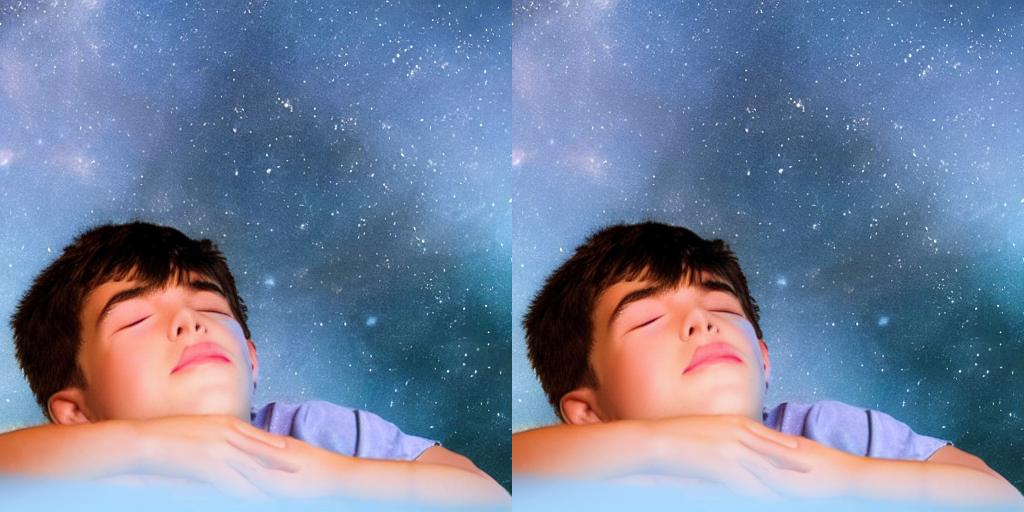

In [ ]:
Image.open('/content/steps/no-style/0199.jpeg')

In [ ]:
!cp -r '/content/steps/no-style' '/content/gdrive/MyDrive/ERA1/s20_stable_diffusion'

# PROMPT : 'A boy running in the style of a tiger'
- 6 Different styles without any loss gudiance

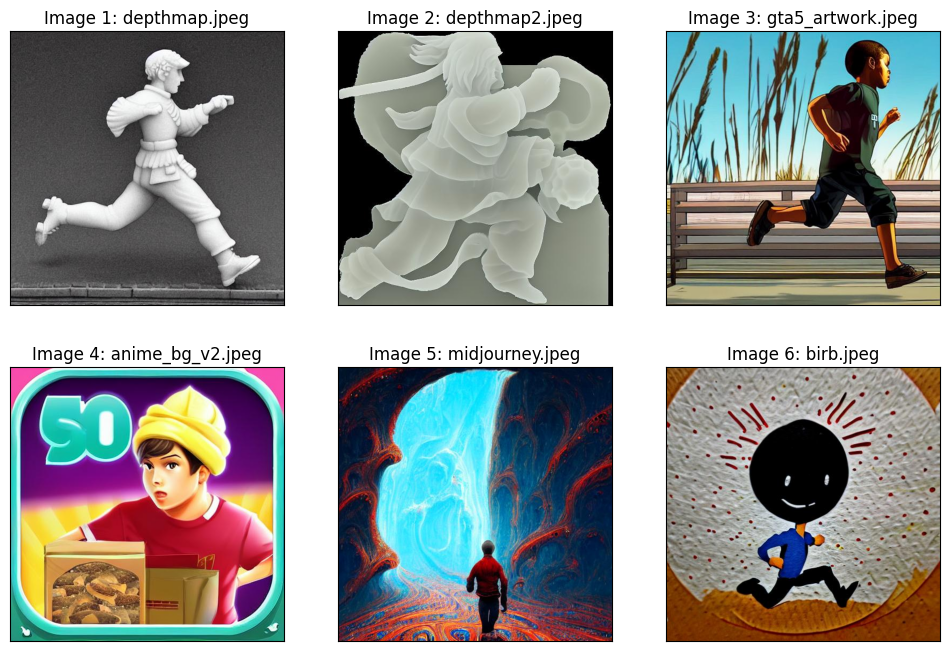

In [ ]:
# Displaying images that were generated for 5 different styles w/o any loss guidnace
# define the folder path where the images are located
folder_path = '/content/steps/images_no_loss'

# get the list of image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpeg')]

# create a new figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the image files and plot them in the subplot
for i, file in enumerate(image_files[:6]):
    # open the image file using Pillow
    image = Image.open(file)

    # get the current subplot
    ax = axs[i//3, i%3]

    # plot the image
    ax.imshow(image)

    # set the title of the subplot to the image file name
    ax.set_title(f'Image {i+1}: {os.path.basename(file)[5:]}')

# hide the x and y axis ticks of the subplots
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# display the subplots
plt.show()

# PROMPT : 'A boy running in the style of a tiger'
- 6 Different styles with percpetual loss gudiance

In [29]:
!mkdir '/content/steps/images_pattern_loss'

In [30]:
!cp '/content/steps/anime_bg_v2/0199.jpeg' '/content/steps/images_pattern_loss/anime_bg_v2_final.jpeg'
!cp '/content/steps/birb/0199.jpeg' '/content/steps/images_pattern_loss/birb_final.jpeg'
!cp '/content/steps/depthmap/0199.jpeg' '/content/steps/images_pattern_loss/depthmap_final.jpeg'
!cp '/content/steps/gta5_artwork/0199.jpeg' '/content/steps/images_pattern_loss/gta5_artwork_final.jpeg'
!cp '/content/steps/midjourney/0199.jpeg' '/content/steps/images_pattern_loss/midjourney_final.jpeg'
!cp '/content/steps/depthmap2/0199.jpeg' '/content/steps/images_pattern_loss/depthmap2_final.jpeg'

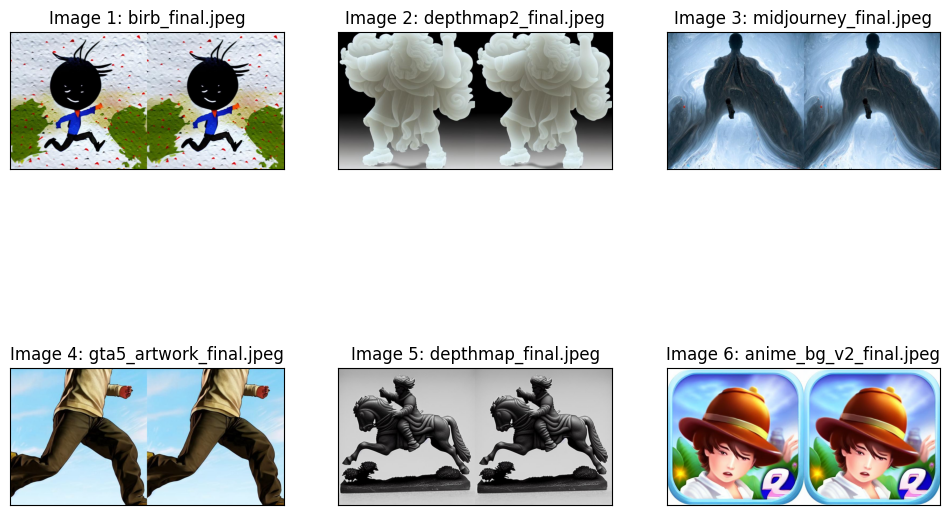

In [31]:
# Displaying images that were generated for 5 different styles with pattern loss guidnace
# define the folder path where the images are located
folder_path = '/content/steps/images_pattern_loss'

# get the list of image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpeg')]

# create a new figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the image files and plot them in the subplot
for i, file in enumerate(image_files[:6]):
    # open the image file using Pillow
    image = Image.open(file)

    # get the current subplot
    ax = axs[i//3, i%3]

    # plot the image
    ax.imshow(image)

    # set the title of the subplot to the image file name
    ax.set_title(f'Image {i+1}: {os.path.basename(file)}')

# hide the x and y axis ticks of the subplots
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# display the subplots
plt.show()

# PROMPT : 'A boy dreaming gazing at stars in the style of a poet'
- 6 Different styles with percpetual loss gudiance

In [ ]:
!mkdir '/content/steps/images_pattern_loss'

In [ ]:
!cp '/content/steps/anime_bg_v2/0199.jpeg' '/content/steps/images_pattern_loss/anime_bg_v2_final.jpeg'
!cp '/content/steps/birb/0199.jpeg' '/content/steps/images_pattern_loss/birb_final.jpeg'
!cp '/content/steps/depthmap/0199.jpeg' '/content/steps/images_pattern_loss/depthmap_final.jpeg'
!cp '/content/steps/gta5_artwork/0199.jpeg' '/content/steps/images_pattern_loss/gta5_artwork_final.jpeg'
!cp '/content/steps/midjourney/0199.jpeg' '/content/steps/images_pattern_loss/midjourney_final.jpeg'
!cp '/content/steps/depthmap2/0199.jpeg' '/content/steps/images_pattern_loss/depthmap2_final.jpeg'

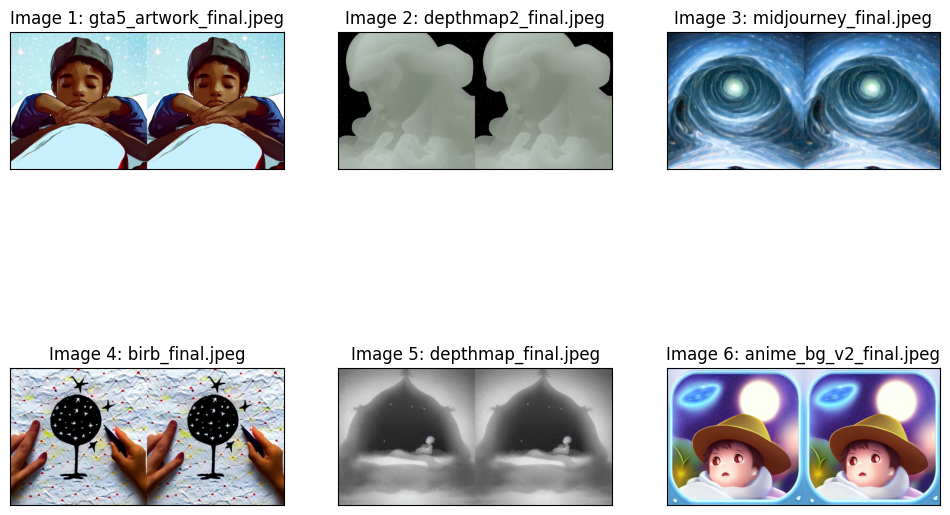

In [ ]:
# Displaying images that were generated for 5 different styles with pattern loss guidnace
# define the folder path where the images are located
folder_path = '/content/steps/images_pattern_loss'

# get the list of image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpeg')]

# create a new figure with 2 rows and 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the image files and plot them in the subplot
for i, file in enumerate(image_files[:6]):
    # open the image file using Pillow
    image = Image.open(file)

    # get the current subplot
    ax = axs[i//3, i%3]

    # plot the image
    ax.imshow(image)

    # set the title of the subplot to the image file name
    ax.set_title(f'Image {i+1}: {os.path.basename(file)}')

# hide the x and y axis ticks of the subplots
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# display the subplots
plt.show()